In order to successfully complete this assignment you need to participate both individually and in groups during class.   Have one of the instructors check your notebook and sign you out before leaving class. Turn in your assignment using D2L. 

---


# In-Class Assignment: Parallel Python

<img src="https://images-na.ssl-images-amazon.com/images/I/41dqFN7dIrL.jpg">

Image from: https://www.amazon.com/


### Agenda for today's class (70 minutes)

1. (20 minutes)[Pre class Review](#Pre-class-Review)
2. (30 minutes)[How do you make Python go faster?](#How-do-you-make-Python-go-faster?)
3. (20 minutes)[Wave Equation](#Wave_Equation)








---
<a name=Pre-class-Review></a>
# 1. Pre class Review


Discuss the pre-class content with your group and work through any questions or challenges you encountered. 


---
<a name=How-do-you-make-Python-go-faster?></a>
# 2. How do you make Python go faster?


&#9989; **<font color=red>DO THIS</font>**: Spend some time searching on Google and record any strategies or libraries that could be used to speed up Python code. Discuss with your group and record all the strategies you could come up with.  

- Use of multithreading library
- Numba
- xrange instead of range for loops

----
<a name="Wave_Equation"></a>

# 3. Wave Equation

In this section we will explore the speed of a 1D wave equation simulation.  This section can be broken up into the following subsections:

<img src="https://i.stack.imgur.com/75vyK.gif" width=25%>


- [Wave equation overview](#Wave_equation_overview)
- [Basic Python Example](#Basic_Python_Example)
- [Vectorizing code with Numpy](#Vectorizing_code_with_Numpy)
- [Compiling Python code using Numba](#Compiling_Python_code_using_Numba)
- [Parallel Python](#Parallel_Python)

<a name="Wave_equation_overview"></a>
## Wave equation overview
This subsection describes the math behind this particular 1D wave simulation.  Knowing this math is not important to the lesson on speeding up code but is included for completness.

The wave equation is a  second-order linear partial differential equation for the description of waves as they occur in classical physics (for example: water waves, sound waves and seismic waves, light waves).  The basic algorithm splits the wave into a grid of points and calculates the point's position, velocity and acceleration.  The key incite to making the wave equations work that an individuals point will lead/follow the behavior of that points neighbors.  


In the 1D case we will model a line of points in the x-direction such that thy can only move in the y direction. The position for each point  $y$ can be calculated by the particle's previous position and the particle's velocity multiplied by the change in time:

$$y_{i+1} = y_i + \dot{y}_idt$$

Notation:
$$\frac{dy}{dt} = \dot{y} = v = \text{velocity of particle in y direction}$$

We calculation the velocity using the acceleration:

$$\dot{y}_{i+1} = \dot{y}_i + \ddot{y}_idt$$

Notation:
$$\frac{d^2y}{dt^2} = \frac{dv}{dt} = \ddot{y} = a = \text{acceleration of particle in y direction}$$


Given the above equations,  if we know the starting values $y_0$, $\dot{y}_0$, $\ddot{y}_0$ then the only unknown is the equation for how the acceleration changes.  

**Wave Equation:** We will estimate acceleration in time by using acceleration in space. Intuitively we can think about this as any point can estimate where it will be in the future by looking at it's neighbors. Mathematically we show this equation as follows:


$$\frac{d^2y}{dt^2} = \gamma\frac{d^2y}{dx^2}$$



We know the acceleration in space using the Euler's finite difference of the particle's position:

$$\frac{d^2y}{dx^2} \approx \frac{y[i+1]-2y[i]+y[i-1]}{dx^2}$$

To get the above equation we estimate the velocity to the Left and Right (Before and After) the point of interest using Finite Difference:

$$\dot{y}[i]_L = \frac{y[i]-y[i-1]}{dx}$$

$$\dot{y}[i]_R = \frac{y[i+1]-y[i]}{dx}$$

Second, using the Left and Right Velocity,  we use finite difference again to estimate the acceleration:

$$\ddot{y}[i] = \frac{\dot{y}[i]_R - \dot{y}[i]_L}{dx}$$

Putting it all together and simplifying we get the followign:

$$\ddot{y}[i] = \frac{y[i+1]-2y[i]+y[i-1]}{dx^2}$$

Given the above we can calculate a point's position at time step $t+1$ by using it's position/velocity at timestep $t$ and it's neighbors position at time step $t-1$.


Pseudocode and settings for 1D Wave Equation

> ### Divide simulation into grid in the x direction
> 
> $xmin = 0; xmax=10; nx=500$
>
> $dx = \frac{xmax-xmin}{nx}$
>
> $x = \text{linspace}(xmin, xmax, nx)$  #Returns a row vector of nx evenly spaced points between xmin and xmax.
>
> ### Divide time into discrete units
>
> $tmin = 0; tmax=10; nt=1000000$
>
> $dt = \frac{tmax-tmin}{nt}$
>
> $times = \text{linespace}(tmin,tmax, nt)$ #Returns a row vector of nt evenly spaced points between tmin and tmax.
>
> ### Initialize starting position as a simple pulse
>
> $y_i = e^{-(x_i-5)^2}$ for all $i \in [0,nx)$
>
> ### Initialize velocity and acceleration to zero
>
> $\dot{y}_i = 0$ for all $i \in [0,nx)$
>
> $\ddot{y}_i = 0$ for all $i \in [0,nx)$
>
> $\gamma = 1$
>
> ### Run the simulation of t timesteps
> Loop over index $t$ in $times$:
>
>    > $\ddot{y}_0 = 0$ # Keep acceleration to zero on ends
>    >
>    > $\ddot{y}_{nx-1} = 0$ # Keep acceleration to zero on ends
>    >
>    > $\ddot{y}_i \approx \gamma \frac{y_{(i+1)} + y_{(i-1)}-2y_i}{dx^2}$ for all $i \in (0,nx-1)$ # Estimate acceleration using position
>    > 
>    > $y_i = y_i + \dot{y}_i dt$   for all $i \in [0,nx)$ # Update position
>    >
>    > $\dot{y}_{i} = \dot{y}_i+ \ddot{y}_idt$   for all $i \in [0,nx)$ # Update velocity


<a name="Basic_Python_Example"></a>
## Basic Python Example

In [18]:
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display, clear_output
import time
def show_animation(delay=0.01):
    fig = plt.gcf()
    time.sleep(delay)       # Sleep for half a second to slow down the animation
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots

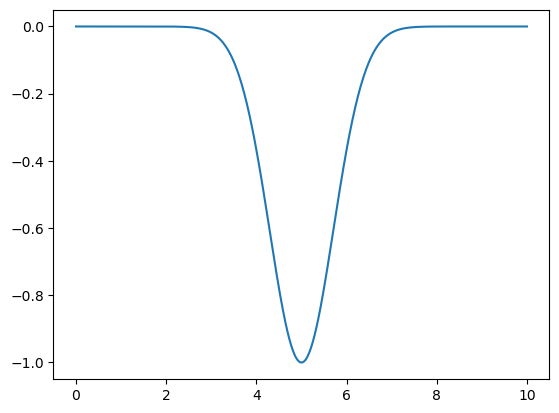

CPU times: user 35.6 s, sys: 326 ms, total: 35.9 s
Wall time: 38.7 s


In [19]:
%%time 
# Python only 1D Wave Example
import math 

show=False
xmin = 0.0
xmax = 10.0
nx = 500
dx = (xmax-xmin)/(nx-1.0)
x = [0.0]*nx
x[0]=0.0
for i in range(1,nx-1):
    x[i]=xmin+i*dx
x[nx-1]=10.0

nt = 100000
tmin = 0.0
tmax = 10.0
dt = (tmax-tmin)/(nt-1.0)
tgrid = [0.0]*nt
tgrid[0]=0.0
for i in range(1,nt-1):
    tgrid[i]=tmin+i*dt
tgrid[nx-1]=10.0


y = [0.0]*nx
v = [0.0]*nx
dvdt = [0.0]*nx
for i in range(0,nx-1):
    y[i] = math.exp(-(x[i]-5.0)**2)

count = 0
for t in tgrid:
    for i in range(1,nx-1):
        dvdt[i]=(y[i+1]+y[i-1]-2.0*y[i])/dx/dx
    for i in range(0,nx-1):
        y[i] = y[i] + v[i]*dt
        v[i] = v[i] + dvdt[i]*dt

    if not count%10000 and show:
        plt.plot(x, y);
        plt.title(count)
        show_animation();
    count += 1


plt.plot(x,y)
show_animation();

&#9989; **<font color=red>DO THIS</font>**: Run the above simple python simulation (It will take a while) with the show variable set to ```True``` and ```False```.  Record the time it takes to run below.

40.6s, 40.1s

<a name="Vectorizing_code_with_Numpy"></a>

## Vectorizing code with Numpy

Numpy uses C-compiled code to speed up Python.  Most slowdown's in code happen when there are big loops.  Numpy uses a lot of very cool tricks (ex vectorization) to make loops go really fast. SO, the trick to making Numpy go fast is to let Numpy run your loops for you.  

Consider the 1D wave equation example:

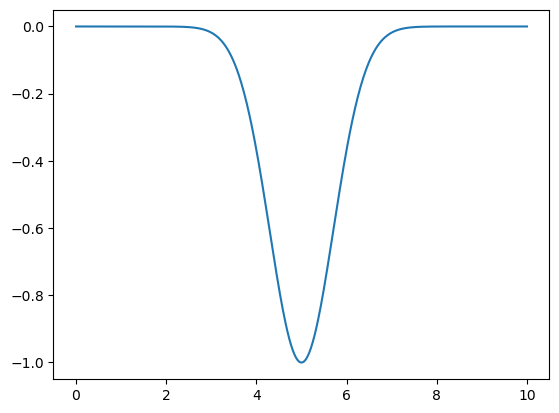

CPU times: user 3.13 s, sys: 50 ms, total: 3.18 s
Wall time: 3.45 s


In [23]:
%%time
#NUMPY 1D Wave Example
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

show = False

xmin = 0.0
xmax = 10.0
nx = 500
gamma = 1
x = np.linspace(xmin, xmax, nx)
dx = (xmax-xmin)/nx

y = np.zeros(nx)
y = np.exp(-(np.array(x)-5.0)**2)

tmin = 0.0
tmax = 10.0
nt = 100000
tgrid = np.linspace(tmin,tmax,nt)
dt = (tmax-tmin)/nt

v = np.zeros(nx)
dvdt = np.zeros(nx)


count = 0
ddx = dx*dx
dvdt2 = dvdt.copy()

count = 0
for t in tgrid:
    #laplacian
    dvdt[1:-1] = gamma*(y[:-2]-2*y[1:-1]+y[2:])/ddx
    y += v*dt
    v += dvdt*dt
    
    if not count%10000 and show:
        plt.plot(x,y)
        plt.title(count)
        show_animation()
    count += 1
plt.plot(x,y)
show_animation()


&#9989; **<font color=red>DO THIS</font>**: Run the above numpy python simulation (It should run much faster) with the show variable set to ```True``` and ```False```.  Record the time it takes to run below.

5.17s, 3.14s

<a name="Compiling_Python_code_using_Numba"></a>
## Compiling Python code using Numba

Numba is a module that takes your standard python function and turns it into c-code then compiles/runs the c version of the funciton.  It can speed things up very nicely.  In this example, we will use the ```@jit``` (Just in time) to convert the code in seciton 2 ([Slow 2D Wave Equation Example](#Slow_2D_Wave_Equation_Example)) to work with numba.  Here are the steps:

1. Import the numba jit module using```from numba import jit```
1. Copy all of your code into a function so jit has something to work with.
3. Add the ```@jit``` with options before the declaration of the function to enable just in time compiling on the function.

In [71]:
import math
from numba import jit

@jit (nopython=True, parallel=True)
def wave_sim():
    show = False
    xmin = 0.0
    xmax = 10.0
    nx = 500
    dx = (xmax-xmin)/(nx-1.0)
    x = [0.0]*nx
    x[0]=0.0
    for i in range(1,nx-1):
        x[i]=xmin+i*dx
    x[nx-1]=10.0

    nt = 100000
    tmin = 0.0
    tmax = 10.0
    dt = (tmax-tmin)/(nt-1.0)
    tgrid = [0.0]*nt
    tgrid[0]=0.0
    for i in range(1,nt-1):
        tgrid[i]=tmin+i*dt
    tgrid[nx-1]=10.0


    y = [0.0]*nx
    v = [0.0]*nx
    dvdt = [0.0]*nx
    for i in range(0,nx-1):
        y[i] = math.exp(-(x[i]-5.0)**2)

    count = 0
    for t in tgrid:
        for i in range(1,nx-1):
            dvdt[i]=(y[i+1]+y[i-1]-2.0*y[i])/dx/dx
        for i in range(0,nx-1):
            y[i] = y[i] + v[i]*dt
            v[i] = v[i] + dvdt[i]*dt

        # if not count%10000 and show:
        #     plt.plot(x, y);
        #     plt.title(count)
        #     show_animation();
        count += 1

    return x,y;


<Figure size 640x480 with 0 Axes>

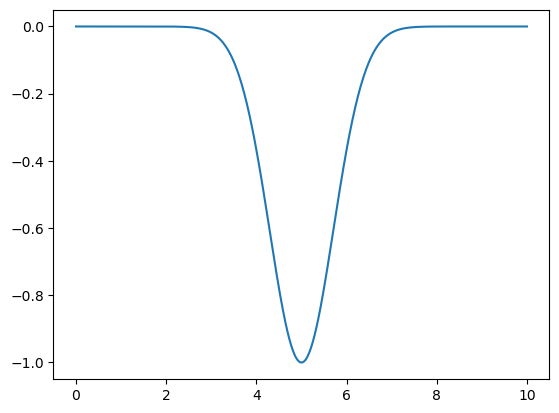

CPU times: user 1.39 s, sys: 27.5 ms, total: 1.42 s
Wall time: 1.5 s


In [73]:
%%time 
%matplotlib inline
import matplotlib.pylab as plt
x,y = wave_sim()
show_animation();
plt.plot(x, y);
plt.show();

&#9989; **<font color=red>DO THIS</font>**: Run the above simple python simulation (It will take a while) with the show variable set to ```True``` and ```False```.  Record the time it takes to run below.  **NOTE:** You will probably get some compile warnings, irgnore these for now.

Doesn't work, 813ms

&#9989; **<font color=red>DO THIS</font>**: Modify the function to only use "core" python methods only. i.e. completely comment out all lines of code that use libraries such as numpy and/or matplotlib. In the above example, comment out lines 42-45.  Record the time it takes to run below.  **NOTE:** This will get rid of the compile warnings from above.


1.43s, 1.38s

<a name="Parallel_Python"></a>

## Parallel Python

Another way to achieve speedup is to utilize multiple processors on your computer. 

&#9989; **<font color=red>DO THIS</font>**: Replace the jit line from above with the following ```@jit (nopython=True, parallel=True)```. When avaliable this will run the code on more than one core. Give it a try and record your results.

1.45s, 1.42s

&#9989; **<font color=red>DO THIS:</font>** Take your results from the entire study and plot them.&#9989; 

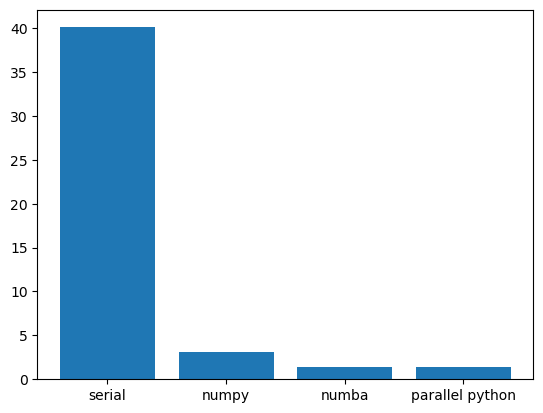

In [77]:
# put your plotting code here.
methods = ['serial', 'numpy', 'numba', 'parallel python']
times = [40.1, 3.14, 1.38, 1.42]
plt.bar(methods, times)
plt.show()



-----
### Congratulations, we're done!

Have one of the instructors check your notebook and sign you out before leaving class. Turn in your assignment using D2L.

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----